# Yöntem 2: Günlük Fiyat Tahmini için RNN Model Eğitimi

Bu notebook'un amacı, bir önceki `feature_engineering` adımında hazırlanan işlenmiş verileri kullanarak bir sonraki günün ortalama elektrik fiyatını tahmin edecek bir RNN (Tekrarlayan Sinir Ağı) modeli oluşturmak, eğitmek ve optimize etmektir.

Süreç aşağıdaki adımları içerecektir:
1.  Gerekli kütüphanelerin yüklenmesi ve ortamın hazırlanması.
2.  Önceden işlenmiş eğitim, validasyon ve test verilerinin yüklenmesi.
3.  Bir başlangıç (baseline) modeli oluşturulup eğitilmesi.
4.  Keras Tuner kullanılarak en iyi model mimarisini ve hiperparametreleri bulmak için optimizasyon yapılması.
5.  Optimize edilmiş en iyi modelin test verisi üzerindeki nihai performansının değerlendirilmesi ve modelin diske kaydedilmesi.

### 1. Kütüphanelerin Yüklenmesi ve Ortam Hazırlığı

İlk olarak, modelleme için gerekli olan `TensorFlow`, `Keras`, `scikit-learn` ve diğer yardımcı kütüphaneleri yüklüyoruz. Ayrıca, işlenmiş verilerin ve eğitilecek modellerin kaydedileceği dosya yollarını (`DATA_PATH`, `MODEL_PATH`) tanımlıyoruz.

In [ ]:
import numpy as np
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, GRU, Dense, Dropout, Attention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Conv1D 


sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

DATA_PATH = '../../data/processed/'
MODEL_PATH = '../../models/'
os.makedirs(MODEL_PATH, exist_ok=True)

### 2. İşlenmiş Verilerin ve Ölçekleyicilerin Yüklenmesi

Bir önceki notebook'ta oluşturup kaydettiğimiz verileri bu adımda yüklüyoruz.

- **`daily_model_data.npz`**: Bu dosya, RNN modelinin beklediği `(örnek_sayısı, dizi_uzunluğu, öznitelik_sayısı)` formatındaki eğitim (`X_train`, `y_train`), validasyon (`X_val`, `y_val`) ve test (`X_test`, `y_test`) dizilerini içerir.
- **`scaler_next_day.joblib`**: Öznitelikleri [0, 1] aralığına ölçeklendirmek için kullanılan `MinMaxScaler` nesnesidir.
- **`scaler_target_next_day.joblib`**: Hedef değişkeni (`target_price_next_day`) [0, 1] aralığına ölçeklendirmek için kullanılan `MinMaxScaler` nesnesidir. Bu, modelin tahminlerini tekrar orijinal Euro birimine çevirmek için kritik öneme sahiptir.

In [ ]:
processed_data = np.load(os.path.join(DATA_PATH, 'daily_model_data.npz'))
X_train = processed_data['X_train']
y_train = processed_data['y_train']
X_val = processed_data['X_val']
y_val = processed_data['y_val']
X_test = processed_data['X_test']
y_test = processed_data['y_test']

scaler_features = joblib.load(os.path.join(DATA_PATH, 'scaler_next_day.joblib'))
scaler_target = joblib.load(os.path.join(DATA_PATH, 'scaler_target_next_day.joblib'))

print("Veri Seti Boyutları:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

Veri Seti Boyutları:
X_train: (23224, 72, 113), y_train: (23224,)
X_val: (4920, 72, 113), y_val: (4920,)
X_test: (4920, 72, 113), y_test: (4920,)


### 3. Model Geliştirme ve Eğitim Süreci

Bu bölümde, önce bir başlangıç (baseline) modeli tanımlayıp eğiteceğiz. Bu model, hiperparametre optimizasyonu sonucunda elde edilecek modelin performansını karşılaştırmak için bir referans noktası sağlayacaktır.

#### 3.1. Başlangıç Modelinin Mimarisi ve Eğitimi
Modelimiz, zaman serisi verilerindeki desenleri yakalamak için tasarlanmış hibrit bir mimariye sahiptir:

- **`Input` Katmanı**: `(72, 113)` boyutunda, yani 72 zaman adımından (saat) ve 113 öznitelikten oluşan dizileri kabul eder.
- **`GRU` Katmanı**: Zaman içindeki sıralı bağımlılıkları öğrenen temel hafıza katmanıdır.
- **`Attention` Katmanı**: GRU katmanının çıktısındaki hangi zaman adımlarının tahmin için daha önemli olduğuna odaklanarak modelin yorumlanabilirliğini ve performansını artırır.
- **`Dense` Katmanları**: Attention mekanizmasından gelen özetlenmiş bilgiyi işleyerek nihai tahmini üretir.
- **`Dropout`**: Aşırı öğrenmeyi (overfitting) engellemek için kullanılır.

Model, eğitim sırasında validasyon kaybını (`val_loss`) izleyen `ModelCheckpoint`, `EarlyStopping` ve `ReduceLROnPlateau` geri çağrıları (callbacks) ile desteklenir.
- **Kaydedilen Dosya**: Bu adımdaki en iyi model, optimizasyon öncesi bir referans olarak `MODEL_PATH` altında **`best_daily_model_initial.keras`** adıyla kaydedilir.

In [12]:
SEQUENCE_LENGTH = X_train.shape[1]
NUM_FEATURES = X_train.shape[2] 

In [ ]:
def build_model(hp):
    input_layer = Input(shape=(SEQUENCE_LENGTH, NUM_FEATURES))

    hp_filters = hp.Int('filters', min_value=32, max_value=96, step=32)
    hp_kernel_size = hp.Choice('kernel_size', values=[6, 8, 12])
    hp_gru_units_1 = hp.Int('gru_units_1', min_value=64, max_value=128, step=32)
    hp_gru_units_2 = hp.Int('gru_units_2', min_value=32, max_value=64, step=32)
    hp_dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    hp_dropout = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    hp_learning_rate = hp.Choice('learning_rate', values=[5e-4, 1e-4, 5e-5]) # Öğrenme oranını biraz daha düşürdük


    # Desen Tanıma Katmanı
    conv_layer = Conv1D(filters=hp_filters, kernel_size=hp_kernel_size, activation='relu')(input_layer)
    
    # Hiyerarşik Hafıza Katmanları
    gru_1 = GRU(units=hp_gru_units_1, return_sequences=True)(conv_layer)
    dropout_1 = Dropout(rate=hp_dropout)(gru_1)
    gru_2 = GRU(units=hp_gru_units_2, return_sequences=True)(dropout_1)

    # Özetleme ve Çıktı
    attention_layer = Attention()([gru_2, gru_2])
    pooling_layer = GlobalAveragePooling1D()(attention_layer)
    
    dense_1 = Dense(units=hp_dense_units, activation='relu')(pooling_layer)
    dropout_2 = Dropout(rate=hp_dropout)(dense_1)
    
    output_layer = Dense(1)(dropout_2)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    optimizer = Adam(learning_rate=hp_learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    return model

In [ ]:
input_layer = Input(shape=(SEQUENCE_LENGTH, NUM_FEATURES), name='input_layer')

gru_layer = GRU(units=128, return_sequences=True, name='gru_layer')(input_layer)
attention_layer = Attention(name='attention_layer')([gru_layer, gru_layer])
pooling_layer = GlobalAveragePooling1D(name='pooling_layer')(attention_layer)

dense_1 = Dense(64, activation='relu', name='dense_1')(pooling_layer)
dropout_1 = Dropout(0.3, name='dropout_1')(dense_1)
dense_2 = Dense(32, activation='relu', name='dense_2')(dropout_1)
dropout_2 = Dropout(0.3, name='dropout_2')(dense_2)

output_layer = Dense(1, name='output_layer')(dropout_2)

model_daily = Model(inputs=input_layer, outputs=output_layer)

model_daily.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model_daily.summary()


checkpoint_path = os.path.join(MODEL_PATH, 'best_daily_model_initial.keras')
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

history = model_daily.fit(
    X_train, y_train, 
    epochs=100,
    batch_size=32, 
    validation_data=(X_val, y_val),
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 72, 113)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_layer (GRU)     │ (None, 72, 128)   │     93,312 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_layer     │ (None, 72, 128)   │          0 │ gru_layer[0][0],  │
│ (Attention)         │                   │            │ gru_layer[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling_layer       │ (None, 128)       │          0 │ attention_layer[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ pooling_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 1)         │         33 │ dropout_2[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 103,681 (405.00 KB)

 Trainable params: 103,681 (405.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - loss: 0.0312 - mean_absolute_error: 0.1279
Epoch 1: val_loss improved from inf to 0.01060, saving model to ../../models/best_daily_model_initial.keras
726/726 ━━━━━━━━━━━━━━━━━━━━ 84s 109ms/step - loss: 0.0311 - mean_absolute_error: 0.1278 - val_loss: 0.0106 - val_mean_absolute_error: 0.0803 - learning_rate: 0.0010
Epoch 2/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0079 - mean_absolute_error: 0.0686
Epoch 2: val_loss improved from 0.01060 to 0.00791, saving model to ../../models/best_daily_model_initial.keras
726/726 ━━━━━━━━━━━━━━━━━━━━ 87s 120ms/step - loss: 0.0079 - mean_absolute_error: 0.0686 - val_loss: 0.0079 - val_mean_absolute_error: 0.0658 - learning_rate: 0.0010
Epoch 3/100
726/726 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - loss: 0.0055 - mean_absolute_error: 0.0566
Epoch 3: val_loss did not improve from 0.00791
726/726 ━━━━━━━━━━━━━━━━━━━━ 103s 143ms/step - loss: 0.0055 - mean_absolute_error: 0.0566 - val_loss:

#### 3.2. Eğitim Geçmişinin Görselleştirilmesi

Modelin eğitim sürecindeki performansını daha iyi anlamak için eğitim ve validasyon setleri üzerindeki kayıp (loss) ve ortalama mutlak hata (MAE) değerlerinin her epoch'taki değişimini görselleştiriyoruz. Bu grafikler, modelin ne kadar iyi öğrendiğini ve aşırı öğrenme olup olmadığını anlamamıza yardımcı olur.

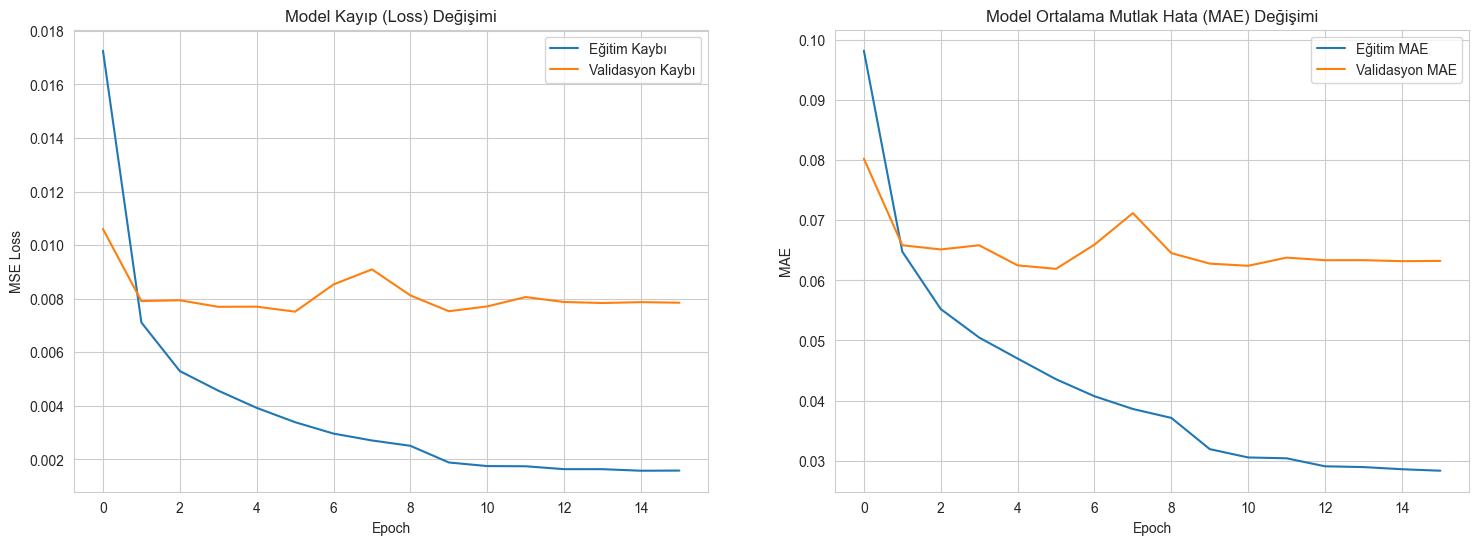

In [15]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.plot(history.history['loss'], label='Eğitim Kaybı')
    ax1.plot(history.history['val_loss'], label='Validasyon Kaybı')
    ax1.set_title('Model Kayıp (Loss) Değişimi')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.legend()
    ax2.plot(history.history['mean_absolute_error'], label='Eğitim MAE')
    ax2.plot(history.history['val_mean_absolute_error'], label='Validasyon MAE')
    ax2.set_title('Model Ortalama Mutlak Hata (MAE) Değişimi')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    plt.show()

plot_training_history(history)



#### 3.3. Başlangıç Modelinin Test Performansı

Eğitilen başlangıç modelini, daha önce hiç görmediği test verisi (`X_test`) üzerinde değerlendiriyoruz. Tahmin edilen ölçeklendirilmiş değerler, `scaler_target` kullanılarak orijinal Euro birimine geri çevrilir ve gerçek değerlerle karşılaştırılarak MAE, RMSE ve R² metrikleri hesaplanır.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred_scaled = model_daily.predict(X_test)

y_pred_original = scaler_target.inverse_transform(y_pred_scaled)
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

mae_original = mean_absolute_error(y_test_original, y_pred_original)
rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print("-" * 50)
print("İyileştirilmiş Modelin Test Performansı (Optimizasyon Öncesi)")
print(f"Ortalama Mutlak Hata (MAE): {mae_original:.2f} Euro")
print(f"Kök Ortalama Kare Hata (RMSE): {rmse_original:.2f} Euro")
print(f"R-Kare (R²) Skoru: {r2:.3f}")
print("-" * 50)

154/154 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step
--------------------------------------------------
İyileştirilmiş Modelin Test Performansı (Optimizasyon Öncesi)
Ortalama Mutlak Hata (MAE): 3.79 Euro
Kök Ortalama Kare Hata (RMSE): 4.62 Euro
R-Kare (R²) Skoru: 0.124
--------------------------------------------------


### 4. Hiperparametre Optimizasyonu (Keras Tuner)

Model performansını daha da iyileştirmek için en iyi hiperparametre kombinasyonunu (katmanlardaki ünite sayısı, filtre sayısı, dropout oranı, öğrenme oranı vb.) otomatik olarak bulmak amacıyla `Keras Tuner` kütüphanesini kullanıyoruz. Optimizasyon için `BayesianOptimization` stratejisi seçilmiştir.

- **`build_model(hp)` fonksiyonu (`execution_count: 13`)**: Bu fonksiyon, tuner'ın her denemede farklı parametrelerle yeni bir model oluşturmasını sağlar.
- **`tuner.search()`**: Optimizasyon sürecini başlatır. Belirlenen `max_trials` sayısı kadar farklı model deneyerek en iyi sonucu arar.
- **Kaydedilen Dosyalar**: Tuner, denemelerin sonuçlarını ve kontrol noktalarını **`keras_tuner_dir_daily/`** klasörüne kaydeder.

In [25]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='keras_tuner_dir_daily',
    project_name='daily_price_tuning_final',
    overwrite=True
)

tuner.search_space_summary()


Search space summary
Default search space size: 7
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 96, 'step': 32, 'sampling': 'linear'}
kernel_size (Choice)
{'default': 6, 'conditions': [], 'values': [6, 8, 12], 'ordered': True}
gru_units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
gru_units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 64, 'step': 32, 'sampling': 'linear'}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
dropout_rate (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.0005, 'conditions': [], 'values': [0.0005, 0.0001, 5e-05], 'ordered': True}


In [26]:
tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping_tuner]
)

early_stopping_tuner = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


Trial 10 Complete [00h 13m 00s]
val_loss: 0.008202873170375824

Best val_loss So Far: 0.007460219785571098
Total elapsed time: 01h 56m 05s


### 5. Final Modelin Değerlendirilmesi ve Kaydedilmesi

Optimizasyon süreci tamamlandıktan sonra, Keras Tuner tarafından bulunan en iyi hiperparametrelere sahip modeli alıp test verisi üzerinde nihai performansını ölçüyoruz.

Bu, projenin en başarılı modelidir ve gelecekteki tahminler için kullanılmak üzere diske kaydedilecektir.

- **Kaydedilen Dosya**: Optimize edilmiş en iyi model, `MODEL_PATH` altında **`best_tuned_daily_model.keras`** adıyla kaydedilir.

In [27]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n--- En İyi Hiperparametreler ---")
print(f"- Conv1D Filtre Sayısı: {best_hps.get('filters')}")
print(f"- Conv1D Kernel Boyutu: {best_hps.get('kernel_size')}")
print(f"- GRU-1 Üniteleri: {best_hps.get('gru_units_1')}")
print(f"- GRU-2 Üniteleri: {best_hps.get('gru_units_2')}")
print(f"- Dense Üniteleri: {best_hps.get('dense_units')}")
print(f"- Dropout Oranı: {best_hps.get('dropout_rate'):.2f}")
print(f"- Öğrenme Oranı: {best_hps.get('learning_rate')}")
print("-" * 30)



--- En İyi Hiperparametreler ---
- Conv1D Filtre Sayısı: 32
- Conv1D Kernel Boyutu: 8
- GRU-1 Üniteleri: 128
- GRU-2 Üniteleri: 64
- Dense Üniteleri: 96
- Dropout Oranı: 0.30
- Öğrenme Oranı: 5e-05
------------------------------


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

best_model = tuner.get_best_models(num_models=1)[0]

print("En İyi Modelin Test Performansı")
y_pred_scaled = best_model.predict(X_test)

y_pred_original = scaler_target.inverse_transform(y_pred_scaled)
y_test_original = scaler_target.inverse_transform(y_test.reshape(-1, 1))

mae_original_best = mean_absolute_error(y_test_original, y_pred_original)
rmse_original_best = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2_best = r2_score(y_test_original, y_pred_original)

print("-" * 50)
print("Test Seti Performans Değerlendirmesi")
print(f"Ortalama Mutlak Hata (MAE): {mae_original_best:.2f} Euro")
print(f"Kök Ortalama Kare Hata (RMSE): {rmse_original_best:.2f} Euro")
print(f"R-Kare (R²) Skoru: {r2_best:.3f}")
print("-" * 50)

best_model.save(os.path.join(MODEL_PATH, 'best_tuned_daily_model.keras'))
print(f"En iyi model '{MODEL_PATH}best_tuned_daily_model.keras' adresine kaydedildi.")

c:\Users\90537\anaconda3\envs\tf-env\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


En İyi Modelin Test Performansı
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step
--------------------------------------------------
Test Seti Performans Değerlendirmesi
Ortalama Mutlak Hata (MAE): 3.69 Euro
Kök Ortalama Kare Hata (RMSE): 4.42 Euro
R-Kare (R²) Skoru: 0.199
--------------------------------------------------
En iyi model '../../models/best_tuned_daily_model.keras' adresine kaydedildi.
